In [1]:
from neo.core import SpikeTrain
from scipy import stats
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr,wilcoxon,mannwhitneyu
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import pair_confusion_matrix,contingency_matrix
from sklearn.metrics.cluster import rand_score
from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
from subprocess import call
from tqdm import tqdm
import dabest as db
import elephant as eph
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import quantities as q
import re
import seaborn as sns
import shutil
import sys
import time
import zipfile
%config Completer.use_jedi = False

In [2]:
def to_significance_label(p):
    if 1.00e-02 < p and p <= 5.00e-02:
        return "*"
    elif 1.00e-03 < p and p <= 1.00e-02:
        return "**"
    elif 1.00e-04 < p and p <= 1.00e-03:
        return "***"
    elif p <= 1.00e-04:
        return "****"
    else:
        return "ns"

def get_connectivity_timeseries(mat_no,odor_no,replicate,switch_prob = 0.3):
    n_n = 120
    p_n = 90
    l_n = 30

    pPNPN = 0.0
    pPNLN = 0.1
    pLNPN = 0.2

    ach_mat = np.zeros((n_n,n_n))
    np.random.seed(64163+mat_no) # Random.org
    ach_mat[p_n:,:p_n] = np.random.choice([0.,1.],size=(l_n,p_n),p=(1-pPNLN,pPNLN))
    ach_mat[:p_n,:p_n] = np.random.choice([0.,1.],size=(p_n,p_n),p=(1-pPNPN,pPNPN))
    
    PNLN = ach_mat[p_n:,:p_n]
    
    LNPN = np.zeros((p_n,l_n))
    stride = int(p_n/l_n)
    spread = (round(pLNPN*p_n)//2)*2+1 # Round to closest odd integer
    center = 0
    index = np.arange(p_n)
    for i in range(l_n):
        idx = index[np.arange(center-spread//2,1+center+spread//2)%p_n]
        LNPN[idx,i] = 1
        center+=stride

    fgaba_mat = np.zeros((n_n,n_n))
    fgaba_mat[:p_n,p_n:] = LNPN # LN->PN
    fgaba_mat[p_n:,p_n:] = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=',') # LN->LN
    np.fill_diagonal(fgaba_mat,0.)

    sgaba_mat = np.zeros((n_n,n_n))
    sgaba_mat[:p_n,p_n:] = LNPN
    np.fill_diagonal(sgaba_mat,0.)

    blocktime = 12000 # in ms
    buffer = 500 # in ms
    sim_res = 0.01 # in ms
    min_block = 50 # in ms

    np.random.seed(mat_no+odor_no+replicate)
    sw_state = [0]
    for i in np.random.choice([0,1],p=[1-switch_prob,switch_prob],size=int(blocktime/min_block)-1):
        if i==1:
            sw_state.append(1-sw_state[-1])
        else:
            sw_state.append(sw_state[-1])
    ts = np.repeat(sw_state,int(min_block/sim_res))
    
    sim_time = blocktime + 2*buffer
    t = np.arange(0,sim_time,sim_res)
    np.random.seed(odor_no)
    setpn = np.concatenate([np.ones(9),np.zeros(81)])
    np.random.shuffle(setpn)
    ts = np.concatenate([np.zeros(int(buffer/sim_res)),ts,np.zeros(int(buffer/sim_res))])
    return PNLN,LNPN,setpn,t,ts

def get_traces(mat_no,odor_no,replicate):
    return np.load(f"Data/data_{mat_no}_{odor_no}_{replicate}.npy")

def get_LN_data(mat_no,odor_no,replicate=None):
    r = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    if replicate is None:
        for i in filter(lambda v: ".npy" in v and f"{mat_no}_{odor_no}" in v,os.listdir('Data')):
            temp = np.load(f"Data/{i}").T
            spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
            event = np.array([SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes],dtype=object)
            bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
            pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
            r.append(pearson_correlation[:,order][order,:])
    else:
        temp = np.load(f"Data/data_{mat_no}_{odor_no}_{replicate}.npy").T
        spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
        event = np.array([SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes],dtype=object)
        bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
        pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
        r.append(pearson_correlation[:,order][order,:])
    return np.nan_to_num(np.array(r)),mat[:,order][order,:],module[order],order

def rankbiserial(x,y,resamples=5000,ci=0.95):
    x = x.flatten()
    y = y.flatten()
    idxs = np.vstack([np.arange(x.shape[0]),np.random.choice(x.shape[0],size=(resamples,x.shape[0]),replace=True)])
    corrs = []
    for idx in idxs:
        d = x[idx]-y[idx]
        r = stats.rankdata(abs(d))
        r_plus = np.sum((d > 0) * r)
        r_minus = np.sum((d < 0) * r)
        p_plus = r_plus/(r_plus+r_minus)
        p_minus = r_minus/(r_plus+r_minus)
        corrs.append(p_plus-p_minus)
    if ci=='sd':
        return corrs[0],np.std(corrs[1:])
    else:
        return corrs[0],(np.quantile(corrs[1:],1-ci),np.quantile(corrs[1:],ci))
    
def cliffdelta(x,y,resamples=5000,ci=0.95):
    x = x.flatten()
    y = y.flatten()
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    idxxs = np.vstack([np.arange(x.shape[0]),np.random.choice(x.shape[0],
                                                              size=(resamples,x.shape[0]),replace=True)])
    idxys = np.vstack([np.arange(y.shape[0]),np.random.choice(y.shape[0],
                                                              size=(resamples,y.shape[0]),replace=True)])
    δs = []
    for i in range(resamples+1):
        U, _ = stats.mannwhitneyu(x[idxxs[i]], y[idxys[i]], alternative='two-sided')
        cliffs_delta = ((2 * U) / (len(x) * len(y))) - 1
        δs.append(cliffs_delta)
    if ci=='sd':
        return δs[0],np.std(δs[1:])
    else:
        return δs[0],(np.quantile(δs[1:],1-ci),np.quantile(δs[1:],ci))
    
def get_module_vector(pn,LNPN,module,order):
    temp = module[(LNPN[pn,:]==1)]
    vec = np.zeros(int(np.max(module)))
    for i in range(1,int(np.max(module))+1):
        vec[i-1] = np.sum(temp==i)
    return vec

def get_PN_data(mat_no,odor_no,replicate=None):
    spike_dist = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    PNLN,LNPN,setpn,_,_ = get_connectivity_timeseries(mat_no,odor_no,1)
    module_space = [get_module_vector(i,LNPN=LNPN,module=module,order=order) for i in np.arange(90)[setpn==1]]
    module_dist = distance_matrix(module_space,module_space)
    for i in filter(lambda v: ".npy" in v and f"{mat_no}_{odor_no}" in v,os.listdir('Data')):
        temp = np.load(f"Data/{i}").T
        spikes = np.logical_and(temp[:90,1:]>=0.,temp[:90,:-1]<0.)
        event = [SpikeTrain(np.linspace(0,12.998,12999)[k>0]*q.s,t_stop=13*q.s) for k in spikes[np.arange(90)[setpn==1]]]
        distance = eph.spike_train_dissimilarity.van_rossum_dist(event,tau=50*q.ms)
        spike_dist.append(distance)
    return np.array(spike_dist),module_dist

def odor_analysis(mat_no,time=None):
    r = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    for odor in [13674, 59428, 72957, 84932, 85036]:
        for replicate in range(1,11):
            temp = np.load(f"Data/data_{mat_no}_{odor}_{replicate}.npy").T
            timeseries = np.linspace(0,12.998,12999)
            endpoint = 13*q.s
            if time is not None:
                temp = temp[:,:int(time*1000)]
                endpoint = time*q.s
                timeseries = np.linspace(0,(int(time*1000)-2)/1000,int(time*1000)-1)
            spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
            event = [SpikeTrain(([0]+list(timeseries[k>0]))*q.s,t_start=0*q.s,t_stop=endpoint) for k in spikes]
            bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
            pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
            r.append(pearson_correlation[:,order][order,:])
    N = len(r)
    r = np.array(r)
    corr_mat = np.ones((N,N))
    for i in range(N):
        for j in range(i):
            corr_mat[i,j] = pearsonr(r[i].flatten(),r[j].flatten())[0]
            corr_mat[j,i] = corr_mat[i,j]
    within = []
    across = []
    for i in range(N//10):
        for j in range(i+1):
            temp = corr_mat[10*i:10*i+10,10*j:10*j+10]
            if i==j:
                within.append(temp[np.tril_indices(10,-1)].flatten())
            else:
                across.append(temp.flatten())
    within = np.concatenate(within)
    across = np.concatenate(across)
    return corr_mat,within[~np.isnan(within)],across[~np.isnan(across)]

In [3]:
def unzip(switch_probx10=3):
    with zipfile.ZipFile(f'zip_0_{switch_probx10}.zip', 'r') as zip_ref:
        for member in tqdm(zip_ref.infolist(), desc='Extracting '):
            try:
                zip_ref.extract(member, "")
            except zipfile.error as e:
                pass
def clean_data():
    for i in os.listdir('Data/'):
        os.remove("Data/"+i)

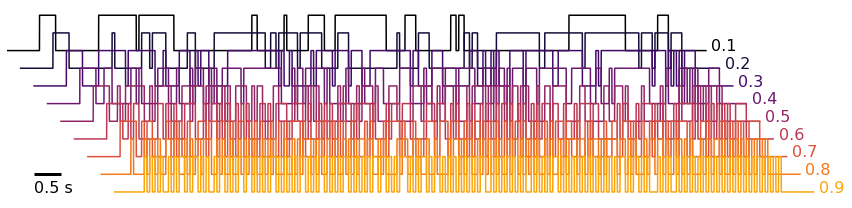

In [3]:
fig,ax = plt.subplots(1,1,figsize=(12,3))
for n, i in enumerate(np.arange(0.1,1,0.1)):
    PNLN,LNPN,setpn,t,ts = get_connectivity_timeseries(2,59428,1,switch_prob=i)
    plt.plot(0.25*n+t/1000,-0.5*n+ts,'k',linewidth=1.5,color=plt.cm.inferno(n/10.))
    plt.text(13.1+0.25*n,-0.5*n,f"{i:0.1f}",fontdict={"fontsize":16},color=plt.cm.inferno(n/10.))
plt.hlines(-3.5,0.5,1.0,color='k',linewidth=3)
plt.text(0.5,-4,"0.5 s",fontdict={"fontsize":16})
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlim(0,15.6)
plt.box(False)
plt.tight_layout()
plt.savefig(f"Figures/IntemittentTimeseries.svg")
# v_traces = get_traces(2,59428,1)
# LN_correlations,mat,module,order = get_LN_data(2,59428,1)

In [88]:
clean_data()

In [6]:
for switch_prob in np.arange(0.1,1,0.1):
    unzip(int(switch_prob*10))
    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            LN_correlations,mat,module,order = get_LN_data(i,j)
            for k in range(10):
                correlation = np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat.flatten())[0,1]
                random_shuffles = [np.random.choice(np.arange(30),size=30,replace=False) for x in range(1000)]
                shuffled = np.mean([np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                results.append((correlation,shuffled))
    results=np.real(np.array(results))
    results = pd.DataFrame(results,columns=["Original","Shuffled"])
    results.to_csv(f"AnalysedData/LNCorrelationAnalysis_0_{int(switch_prob*10)}.csv")

    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            LN_correlations,mat,module,order = get_LN_data(i,j)
            for k in range(10):
                cluster_model = KMeans(n_clusters=int(np.max(module)))
                cluster_model.fit((1-LN_correlations[k])/2)
                f_correctpairs = rand_score(cluster_model.labels_,np.int32(module-1))
                random_clustering = [np.random.choice(np.arange(4),size=30) for x in range(1000)]
                shuffled = np.mean([rand_score(cluster_model.labels_,cluster) for cluster in random_clustering])
                results.append((f_correctpairs,shuffled))
    results = np.real(np.array(results))
    results = pd.DataFrame(results,columns=["Newman","Random"])
    results.to_csv(f"AnalysedData/LNReconstructionAnalysis_0_{int(switch_prob*10)}.csv")

    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            spike_dist,module_dist = get_PN_data(i,j)
            for k in range(10):
                correlation = np.corrcoef(np.nan_to_num(spike_dist[k]).flatten(),module_dist.flatten())[0,1]
                random_shuffles = [np.random.choice(np.arange(9),size=9,replace=False) for x in range(1000)]
                shuffled = np.mean([np.corrcoef(np.nan_to_num(spike_dist[k]).flatten(),module_dist[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                results.append((correlation,shuffled))
    results=np.array(results)
    results = pd.DataFrame(results,columns=["Original","Shuffled"])
    results.to_csv(f"AnalysedData/PNCorrelationAnalysis_0_{int(switch_prob*10)}.csv")

    results= [[],[]]
    for i in tqdm(range(1,11)):
        summary_matrix,within,across = odor_analysis(i)
        for j in within:
            results[0].append(j)
        for j in across:
            results[1].append(j)
    N = max(len(results[0]),len(results[1]))
    temp = np.nan*np.ones((N,2))
    temp[:len(results[0]),0] = results[0]
    temp[:len(results[1]),1] = results[1]
    results=np.real(temp)
    results = pd.DataFrame(results,columns=["Within","Across"])
    results.to_csv(f"AnalysedData/OdorComparision_0_{int(switch_prob*10)}.csv")

    results= []
    for time in tqdm(np.arange(0.5,13.5,0.5)):
        for i in range(1,11):
            _,within,across = odor_analysis(i,time=time)
            for j in within:
                if not np.isnan(j):
                    results.append((time,"Within Odors",j))
            for j in across:
                if not np.isnan(j):
                    results.append((time,"Across Odors",j))
    results=np.real(np.array(results))
    results = pd.DataFrame(results,columns=["Time","LN Dynamics Correlation","Correlation"])
    results['Time'] = np.float32(results['Time'])
    results['Correlation'] = np.float32(results['Correlation'])
    results.to_csv(f"AnalysedData/OdorComparisionTimeseries_0_{int(switch_prob*10)}.csv")

    clean_data()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  warnings.warn(
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:542: RuntimeWarning: invalid value encountered in true_divide
  res /= (stdx.T * stdx)
  0%|                                                                                           | 0/10 [00:00<?, ?it/s]D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: 

D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  warnings.warn(
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:542: RuntimeWarning: invalid value encountered in true_divide
  res /= (stdx.T * stdx)
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  warnings.warn(
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:542: RuntimeWarning: invalid value encountered in true_divide
 

D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  warnings.warn(
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:542: RuntimeWarning: invalid value encountered in true_divide
  res /= (stdx.T * stdx)
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 70%|

 10%|████████▎                                                                          | 1/10 [00:29<04:25, 29.53s/it]D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 30%|████████████████████████▉                                                          | 3/10 [01:28<03:26, 29.47s/it]D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\Anaconda3\envs\odor-states\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
 40%|█████████████████████████████████▏                                                 | 4/10 [01:57<02:55, 29.30s/it

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.6_Original vs. 0.7_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=6.104e+04
0.7_Original vs. 0.9_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.100e-61 Stat=8.844e+03
0.1_Original vs. 0.6_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val:3.863e-83 Stat=3.000e+00


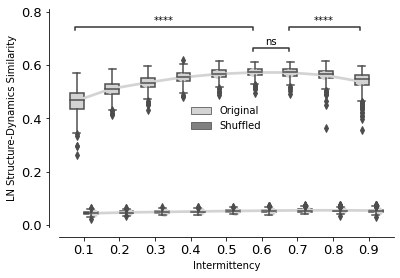

In [32]:
# bpx = [((0.5, 'Original'), (0.6, 'Original')),
#  ((0.4, 'Original'), (0.5, 'Original')),
#  ((0.8, 'Original'), (0.9, 'Original')),
#  ((0.7, 'Original'), (0.8, 'Original')),
#  ((0.6, 'Original'), (0.7, 'Original')),
#  ((0.1, 'Original'), (0.2, 'Original')),
#  ((0.2, 'Original'), (0.3, 'Original')),
#  ((0.3, 'Original'), (0.4, 'Original'))]
bpx = [((0.1, 'Original'), (0.6, 'Original')),
       ((0.7, 'Original'), (0.9, 'Original')),
       ((0.6, 'Original'), (0.7, 'Original'))]

df = pd.DataFrame()
for i in filter(lambda v: "LNCorrelationAnalysis" in v,os.listdir('AnalysedData/')):
    temp = pd.read_csv(f"AnalysedData/{i}",index_col=0)
    temp['Intermittency'] = int(i.split('_')[2][:-4])/10
    df = pd.concat((df,temp))

df = df.melt('Intermittency',var_name="Neuron Order",value_name="Structure-Dynamics Similarity")

plt.figure(figsize=(6,4))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.pointplot(x='Intermittency',y='Structure-Dynamics Similarity', data=df,
              palette='blend:lightgrey,lightgrey',ci=None,capsize=0.1, hue='Neuron Order',dodge=0.5)
plt.setp(ax.lines, zorder=0)
plt.setp(ax.collections, zorder=1, label="")
ax = sns.boxplot(x='Intermittency',y='Structure-Dynamics Similarity',
                 data=df,palette='blend:lightgrey,grey',hue='Neuron Order')#,scale='width',ci='sd',capsize=0.1)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
sns.despine(offset=10, trim=False)

annotator = Annotator(ax, bpx, data=df, x='Intermittency',y='Structure-Dynamics Similarity',
                                       hue="Neuron Order", width=1)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
ax.legend(frameon=False)
ax.set_ylabel("LN Structure-Dynamics Similarity")
plt.savefig(f"Figures/LNCorrelationAnalysis.svg")

In [34]:
x = []
y = []
p = []
yerr = []
for i in tqdm(np.unique(df.Intermittency)):
    temp = rankbiserial(df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Original")]["Structure-Dynamics Similarity"].values,
                    df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Shuffled")]["Structure-Dynamics Similarity"].values)
    pval = wilcoxon(df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Original")]["Structure-Dynamics Similarity"].values,
                    df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Shuffled")]["Structure-Dynamics Similarity"].values).pvalue
    p.append(to_significance_label(500*pval))
    x.append(i)
    y.append(temp[0])
    yerr.append(temp[1])

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.62it/s]


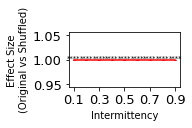

In [36]:
plt.figure(figsize=(2,1))
plt.errorbar(x,y,yerr=np.abs(np.array(yerr).T-np.tile(y,2).reshape(2,9)),capsize=1,color='red')
for i in range(9):
    plt.text(x[i],np.array(yerr)[:,1][i],p[i],ha='center',fontdict={'size':7})
plt.xticks(np.arange(0.1,1.0,0.2))
plt.xlabel("Intermittency")
plt.ylabel("Effect Size\n(Original vs Shuffled)")
plt.savefig(f"Figures/LNCorrelationAnalysis_effect.svg")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.6_Newman vs. 0.9_Newman: Wilcoxon test (paired samples) with Bonferroni correction, P_val:3.443e-06 Stat=4.318e+04
0.1_Newman vs. 0.6_Newman: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.286e-15 Stat=3.027e+04


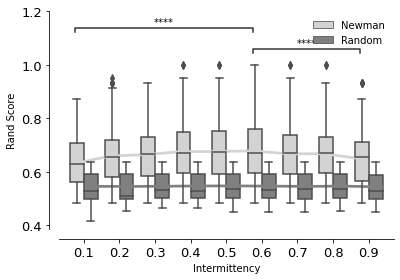

In [29]:
# bpx = [((0.5, 'Newman'), (0.6, 'Newman')),
#  ((0.4, 'Newman'), (0.5, 'Newman')),
#  ((0.8, 'Newman'), (0.9, 'Newman')),
#  ((0.7, 'Newman'), (0.8, 'Newman')),
#  ((0.6, 'Newman'), (0.7, 'Newman')),
#  ((0.1, 'Newman'), (0.2, 'Newman')),
#  ((0.2, 'Newman'), (0.3, 'Newman')),
#  ((0.3, 'Newman'), (0.4, 'Newman'))]
bpx = [((0.1, 'Newman'), (0.6, 'Newman')),
 ((0.6, 'Newman'), (0.9, 'Newman'))]

df = pd.DataFrame()
for i in filter(lambda v: "LNReconstructionAnalysis" in v,os.listdir('AnalysedData/')):
    temp = pd.read_csv(f"AnalysedData/{i}",index_col=0)
    temp['Intermittency'] = int(i.split('_')[2][:-4])/10
    df = pd.concat((df,temp))

df = df.melt('Intermittency',var_name="Clustering Method",value_name="Rand Score")

plt.figure(figsize=(6,4))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.pointplot(x='Intermittency',y='Rand Score', data=df,
              palette='blend:lightgrey,grey',ci=None,capsize=0.1, hue='Clustering Method',dodge=0.5)
plt.setp(ax.lines, zorder=1)
plt.setp(ax.collections, zorder=1, label="")
ax = sns.boxplot(x='Intermittency',y='Rand Score',
                 data=df,palette='blend:lightgrey,grey',hue='Clustering Method')
#                     ,scale='width',ci='sd',capsize=0.1, )
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
sns.despine(offset=10, trim=False)
annotator = Annotator(ax, bpx, data=df, x='Intermittency',y='Rand Score',
                                       hue="Clustering Method", width=1)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside', verbose=2,comparisons_correction='bonferroni')
annotator.apply_and_annotate()
ax.legend(frameon=False)
# plt.vlines(1.6,results["Shuffled"].mean(),results["Newman"].mean(),linewidth=2,colors='k')
# plt.text(1.7,results.values.mean(),f"eff size: {eff:0.2f}",rotation=270,va='center')
plt.savefig(f"Figures/LNReconstructionAnalysis.svg")

In [30]:
x = []
y = []
yerr = []
p = []
for i in tqdm(np.unique(df.Intermittency)):
    temp = rankbiserial(df[np.logical_and(df.Intermittency==i,df["Clustering Method"]=="Newman")]["Rand Score"].values,
                    df[np.logical_and(df.Intermittency==i,df["Clustering Method"]=="Random")]["Rand Score"].values)
    pval = wilcoxon(df[np.logical_and(df.Intermittency==i,df["Clustering Method"]=="Newman")]["Rand Score"].values,
        df[np.logical_and(df.Intermittency==i,df["Clustering Method"]=="Random")]["Rand Score"].values).pvalue
    p.append(to_significance_label(500*pval))
    x.append(i)
    y.append(temp[0])
    yerr.append(temp[1])

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.65it/s]


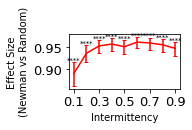

In [31]:
plt.figure(figsize=(2,1))
plt.errorbar(x,y,yerr=np.abs(np.array(yerr).T-np.tile(y,2).reshape(2,9)),capsize=2,color='red')
for i in range(9):
    plt.text(x[i],np.array(yerr)[:,1][i],p[i],ha='center',fontdict={'size':7})
plt.xticks(np.arange(0.1,1.0,0.2))
plt.xlabel("Intermittency")
plt.ylabel("Effect Size\n(Newman vs Random)")
plt.savefig(f"Figures/LNReconstructionAnalysis_effect.svg")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
0.1_Original v.s. 0.3_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.083e-10 stat=4.142e+04
Using zero_method  wilcox
0.3_Original v.s. 0.9_Original: Wilcoxon test (paired samples) with Bonferroni correction, P_val=3.273e-12 stat=3.980e+04


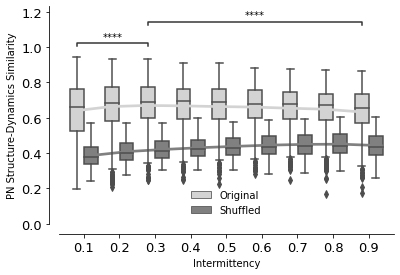

In [54]:
# bpx = [((0.5, 'Original'), (0.6, 'Original')),
#  ((0.4, 'Original'), (0.5, 'Original')),
#  ((0.8, 'Original'), (0.9, 'Original')),
#  ((0.7, 'Original'), (0.8, 'Original')),
#  ((0.6, 'Original'), (0.7, 'Original')),
#  ((0.1, 'Original'), (0.2, 'Original')),
#  ((0.2, 'Original'), (0.3, 'Original')),
#  ((0.3, 'Original'), (0.4, 'Original'))]
bpx = [((0.1, 'Original'), (0.3, 'Original')),
 ((0.3, 'Original'), (0.9, 'Original'))]

df = pd.DataFrame()
for i in filter(lambda v: "PNCorrelationAnalysis" in v,os.listdir('AnalysedData/')):
    temp = pd.read_csv(f"AnalysedData/{i}",index_col=0)
    temp['Intermittency'] = int(i.split('_')[2][:-4])/10
    
    df = pd.concat((df,temp))

df = df.melt('Intermittency',var_name="Neuron Order",value_name="Structure-Dynamics Similarity")

plt.figure(figsize=(6,4))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.pointplot(x='Intermittency',y='Structure-Dynamics Similarity', data=df,
              palette='blend:lightgrey,grey',ci=None,capsize=0.1, hue='Neuron Order',dodge=0.5)
plt.setp(ax.lines, zorder=1)
plt.setp(ax.collections, zorder=1, label="")
ax = sns.boxplot(x='Intermittency',y='Structure-Dynamics Similarity',
                 data=df,palette='blend:lightgrey,grey', hue='Neuron Order')
#                     ,scale='width',ci='sd',capsize=0.1)
sns.despine(offset=10, trim=False)
ax.set_ylim(0,1)
ax, test_results = add_stat_annotation(ax, data=df, x='Intermittency',y='Structure-Dynamics Similarity',
                                       hue="Neuron Order",
                                       box_pairs=bpx,
                                   test='Wilcoxon', text_format='star', loc='inside', verbose=2)
ax.legend(frameon=False)
# plt.vlines(1.6,results["Shuffled"].mean(),results["Original"].mean(),linewidth=2,colors='k')
# plt.text(1.7,results.values.mean(),f"eff size: {eff:0.2f}",rotation=270,va='center')
ax.set_ylabel("PN Structure-Dynamics Similarity")
plt.savefig(f"Figures/PNCorrelationAnalysis.svg")

In [55]:
x = []
y = []
yerr = []
p = []
for i in tqdm(np.unique(df.Intermittency)):
    temp = rankbiserial(df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Original")]["Structure-Dynamics Similarity"].values,
                    df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Shuffled")]["Structure-Dynamics Similarity"].values)
    pval = wilcoxon(df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Original")]["Structure-Dynamics Similarity"].values,
    df[np.logical_and(df.Intermittency==i,df["Neuron Order"]=="Shuffled")]["Structure-Dynamics Similarity"].values).pvalue
    p.append(to_significance_label(500*pval))
    x.append(i)
    y.append(temp[0])
    yerr.append(temp[1])

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.69it/s]


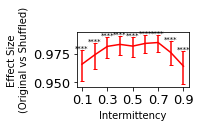

In [56]:
plt.figure(figsize=(2,1))
plt.errorbar(x,y,yerr=np.abs(np.array(yerr).T-np.tile(y,2).reshape(2,9)),capsize=2,color='red')
for i in range(9):
    plt.text(x[i],np.array(yerr)[:,1][i],p[i],ha='center',fontdict={'size':7})
plt.xticks(np.arange(0.1,1.0,0.2))
plt.xlabel("Intermittency")
plt.ylabel("Effect Size\n(Original vs Shuffled)")
plt.savefig(f"Figures/PNCorrelationAnalysis_effect.svg")

In [141]:
bpx = [((0.5, 'Original'), (0.6, 'Original')),
 ((0.4, 'Original'), (0.5, 'Original')),
 ((0.8, 'Original'), (0.9, 'Original')),
 ((0.7, 'Original'), (0.8, 'Original')),
 ((0.6, 'Original'), (0.7, 'Original')),
 ((0.1, 'Original'), (0.2, 'Original')),
 ((0.2, 'Original'), (0.3, 'Original')),
 ((0.3, 'Original'), (0.4, 'Original'))]
df = pd.DataFrame()
for i in filter(lambda v: "OdorComparision_" in v,os.listdir('AnalysedData/')):
    temp = pd.read_csv(f"AnalysedData/{i}",index_col=0)
    temp['Intermittency'] = int(i.split('_')[2][:-4])/10
    
    df = pd.concat((df,temp))

In [142]:
t1 = df.drop('Across',axis=1)
t1.columns = ["Correlation","Intermittency"]
t1["Identity"] = "Within"
t2 = df.drop('Within',axis=1)
t2.columns = ["Correlation","Intermittency"]
t2["Identity"] = "Across"
df = pd.concat([t1,t2]).dropna()

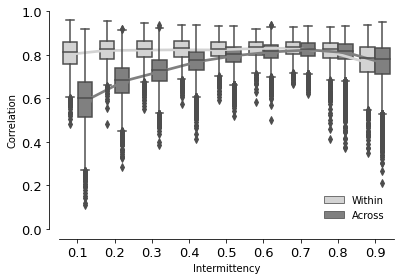

In [143]:
plt.figure(figsize=(6,4))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 
ax = sns.pointplot(x='Intermittency',y='Correlation', data=df,
              palette='blend:lightgrey,grey',ci=None,capsize=0.1, hue='Identity',dodge=0.5)
plt.setp(ax.lines, zorder=1)
plt.setp(ax.collections, zorder=1, label="")
ax = sns.boxplot(x='Intermittency',y='Correlation',
                 data=df,palette='blend:lightgrey,grey', hue='Identity')
#                     ,scale='width',ci='sd',capsize=0.1)
sns.despine(offset=10, trim=False)
ax.set_ylim(0,1)
# ax, test_results = add_stat_annotation(ax, data=df, x='Intermittency',y='Correlation',
#                                        hue='Identity',
#                                        box_pairs=bpx,
#                                    test='Wilcoxon', text_format='star', loc='inside', verbose=2)
ax.legend(frameon=False)
# plt.vlines(1.6,results["Shuffled"].mean(),results["Original"].mean(),linewidth=2,colors='k')
# plt.text(1.7,results.values.mean(),f"eff size: {eff:0.2f}",rotation=270,va='center')
plt.savefig(f"Figures/LNOdorDifference.svg")

In [144]:
x = []
y = []
yerr = []
p = []
for i in tqdm(np.unique(df.Intermittency)):
    temp = cliffdelta(df[np.logical_and(df.Intermittency==i,df["Identity"]=="Within")]["Correlation"].values,
                    df[np.logical_and(df.Intermittency==i,df["Identity"]=="Across")]["Correlation"].values)
    pval = mannwhitneyu(df[np.logical_and(df.Intermittency==i,df["Identity"]=="Within")]["Correlation"].values,
    df[np.logical_and(df.Intermittency==i,df["Identity"]=="Across")]["Correlation"].values).pvalue
    p.append(to_significance_label(500*pval))
    x.append(i)
    y.append(temp[0])
    yerr.append(temp[1])

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:54<00:00, 12.71s/it]


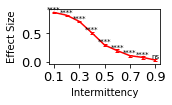

In [145]:
plt.figure(figsize=(2,1))
plt.errorbar(x,y,yerr=np.abs(np.array(yerr).T-np.tile(y,2).reshape(2,9)),capsize=2,color='red')
for i in range(9):
    plt.text(x[i],np.array(yerr)[:,1][i],p[i],ha='center',fontdict={'size':7})
plt.xticks(np.arange(0.1,1.0,0.2))
plt.xlabel("Intermittency")
plt.ylabel("Effect Size")
plt.savefig(f"Figures/LNOdorDifference_effect.svg")

In [66]:
bpx = [((0.5, 'Original'), (0.6, 'Original')),
 ((0.4, 'Original'), (0.5, 'Original')),
 ((0.8, 'Original'), (0.9, 'Original')),
 ((0.7, 'Original'), (0.8, 'Original')),
 ((0.6, 'Original'), (0.7, 'Original')),
 ((0.1, 'Original'), (0.2, 'Original')),
 ((0.2, 'Original'), (0.3, 'Original')),
 ((0.3, 'Original'), (0.4, 'Original'))]
df = pd.DataFrame()
for i in filter(lambda v: "OdorComparisionTimeseries_" in v,os.listdir('AnalysedData/')):
    temp = pd.read_csv(f"AnalysedData/{i}",index_col=0)
    temp['Intermittency'] = int(i.split('_')[2][:-4])/10
    df = pd.concat((df,temp))

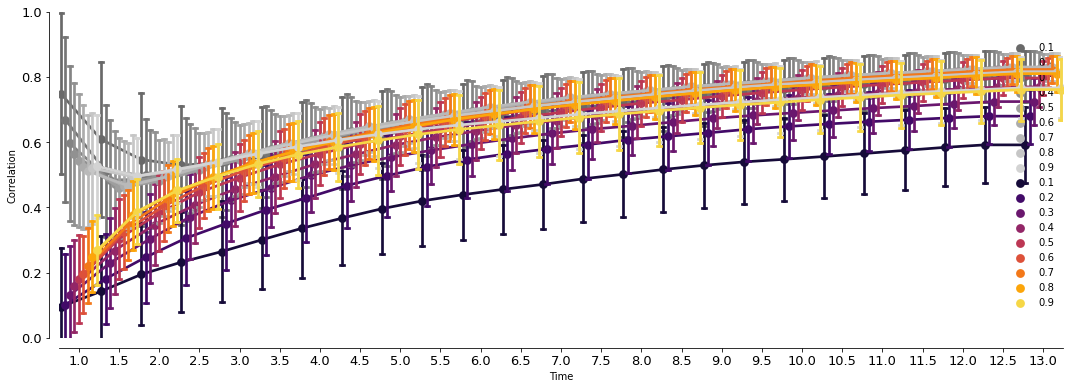

In [67]:
plt.figure(figsize=(18,6))
mpl.rc('xtick', labelsize=13) 
mpl.rc('ytick', labelsize=13) 

ax1 = sns.pointplot(x='Time',y='Correlation', data=df[df["LN Dynamics Correlation"]=='Within Odors'],
              palette='blend:dimgrey,lightgrey',ci='sd',capsize=0.1, hue='Intermittency',dodge=0.9)
ax2 = sns.pointplot(x='Time',y='Correlation', data=df[df["LN Dynamics Correlation"]=='Across Odors'],
              palette='inferno',ci='sd',capsize=0.1, hue='Intermittency',dodge=0.9)
sns.despine(offset=10, trim=False)
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
ax1.legend(frameon=False,loc='center right')
ax2.legend(frameon=False,loc='center right')
plt.savefig(f"Figures/LNOdorDifferenceTimeseries.svg")

In [68]:
df

,Time,LN Dynamics Correlation,Correlation,Intermittency
0,1.0,Within Odors,0.638131,0.1
1,1.0,Within Odors,0.528309,0.1
2,1.0,Within Odors,0.551448,0.1
3,1.0,Within Odors,0.968856,0.1
4,1.0,Within Odors,0.664439,0.1
...,...,...,...,...
306245,13.0,Across Odors,0.834265,0.9
306246,13.0,Across Odors,0.795045,0.9
306247,13.0,Across Odors,0.839527,0.9
306248,13.0,Across Odors,0.803824,0.9


In [69]:
emat = np.zeros((len(np.unique(df.Time)),len(np.unique(df.Intermittency))))
pmat = np.zeros((len(np.unique(df.Time)),len(np.unique(df.Intermittency))))
for m,t in enumerate(np.unique(df.Time)):
    for n,i in tqdm(enumerate(np.unique(df.Intermittency))):
        temp = df[np.logical_and(df.Time==t,df.Intermittency==i)]
        emat[m,n] = cliffdelta(temp[temp["LN Dynamics Correlation"]=="Within Odors"]["Correlation"].values,
                               temp[temp["LN Dynamics Correlation"]=="Across Odors"]["Correlation"].values)[0]
        pmat[m,n] = mannwhitneyu(temp[temp["LN Dynamics Correlation"]=="Within Odors"]["Correlation"].values,
                               temp[temp["LN Dynamics Correlation"]=="Across Odors"]["Correlation"].values).pvalue

9it [01:41, 11.30s/it]
9it [01:50, 12.22s/it]
9it [01:51, 12.39s/it]
9it [01:52, 12.47s/it]
9it [01:53, 12.64s/it]
9it [01:48, 12.01s/it]
9it [01:47, 11.91s/it]
9it [01:48, 12.08s/it]
9it [02:01, 13.51s/it]
9it [01:58, 13.19s/it]
9it [02:00, 13.38s/it]
9it [02:04, 13.80s/it]
9it [02:05, 13.98s/it]
9it [02:04, 13.87s/it]
9it [02:06, 14.09s/it]
9it [01:53, 12.57s/it]
9it [01:50, 12.24s/it]
9it [01:57, 13.03s/it]
9it [02:02, 13.62s/it]
9it [02:08, 14.26s/it]
9it [02:05, 13.95s/it]
9it [02:07, 14.11s/it]
9it [02:09, 14.41s/it]
9it [01:54, 12.77s/it]
9it [01:48, 12.07s/it]


In [74]:
from scipy import ndimage
data = pd.DataFrame(emat.T,index=np.unique(df.Intermittency),columns=np.unique(df.Time))
datap = pd.DataFrame(pmat.T,index=np.unique(df.Intermittency),columns=np.unique(df.Time))
data.to_csv("AnalysedData/emat.csv")
datap.to_csv("AnalysedData/pmat.csv")

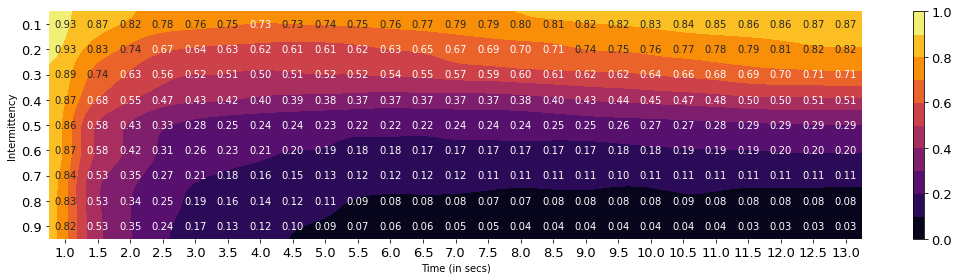

In [75]:
fig, ax = plt.subplots(figsize=(15,4))
smooth_scale = 5
z = ndimage.zoom(data.to_numpy(), smooth_scale)

cntr = ax.contourf(np.linspace(0, len(data.columns), len(data.columns) * smooth_scale),
                   np.linspace(0, len(data.index), len(data.index) * smooth_scale),
                   z, levels=np.linspace(0,1,11), cmap='inferno')
ax = sns.heatmap(data, annot=True, fmt='0.2f', alpha=0, cbar=False, ax=ax)
plt.colorbar(cntr, ax=ax)
plt.yticks(rotation=0) 
plt.xticks(rotation=0) 
plt.xlabel("Time (in secs)")
plt.ylabel("Intermittency")
plt.tight_layout()
plt.savefig(f"Figures/LNOdorEffectTimeseries_alt.svg")
plt.show()

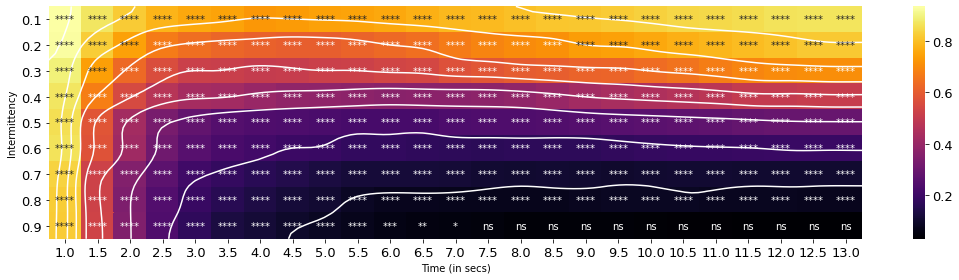

In [76]:
fig, ax = plt.subplots(figsize=(15,4))

smooth_scale = 5
z = ndimage.zoom(data.to_numpy(), smooth_scale)
cntr = ax.contour(np.linspace(0, len(data.columns), len(data.columns) * smooth_scale),
                  np.linspace(0, len(data.index), len(data.index) * smooth_scale),
                  z, levels=np.linspace(0,1,11), colors='white')
ax = sns.heatmap(data, annot=datap.applymap(lambda v: to_significance_label(500*v)), fmt="", cbar=True, ax=ax, cmap='inferno')
plt.yticks(rotation=0) 
plt.xticks(rotation=0) 
plt.xlabel("Time (in secs)")
plt.ylabel("Intermittency")
plt.tight_layout()
plt.show()

In [90]:
for switch_prob in np.arange(0.1,1,0.1):
    unzip(int(switch_prob*10))
    results= []
    for time in tqdm(np.arange(0.5,13.5,0.5)):
        for i in range(1,11):
            _,within,across = odor_analysis(i,time=time)
            for j in within:
                if not np.isnan(j):
                    results.append((time,"Within Odors",j))
            for j in across:
                if not np.isnan(j):
                    results.append((time,"Across Odors",j))
    results=np.real(np.array(results))
    results = pd.DataFrame(results,columns=["Time","LN Dynamics Correlation","Correlation"])
    results['Time'] = np.float32(results['Time'])
    results['Correlation'] = np.float32(results['Correlation'])
    results = {'x1':[],'x2':[],'y':[]}
    for mat_no in tqdm(range(1,11)):
        random_shuffles = [np.random.choice(np.arange(5),size=5,replace=False) for x in range(1000)]
        LN_inputs = []
        for odor in [13674, 59428, 72957, 84932, 85036]:
            PNLN,LNPN,setpn,_,_ = get_connectivity_timeseries(mat_no,odor,1)
            LN_inputs.append(PNLN@setpn)
        LN_inputs = np.tile(LN_inputs,10).reshape(-1,30)
        LN_odor_matrix = distance_matrix(LN_inputs,LN_inputs)
        PN_inputs = []
        for odor in [13674, 59428, 72957, 84932, 85036]:
            PNLN,LNPN,setpn,_,_ = get_connectivity_timeseries(mat_no,odor,1)
            PN_inputs.append(setpn)
        PN_inputs = np.tile(PN_inputs,10).reshape(-1,90)
        PN_odor_matrix = distance_matrix(PN_inputs,PN_inputs)
        results['x1'].append(PN_odor_matrix[np.tril_indices(50,-1)])
        results['x2'].append(LN_odor_matrix[np.tril_indices(50,-1)])
        corr_mat,_,_ = odor_analysis(mat_no,time=13)
        results['y'].append(corr_mat[np.tril_indices(50,-1)])
    for k in results.keys():
        results[k] = np.concatenate(results[k])
    pd.DataFrame(results).to_csv(f"AnalysedData/Distance_{int(switch_prob*10)}.csv")
# results.to_csv(f"AnalysedData/OdorComparisionTimeseries_0_{int(switch_prob*10)}.csv")

  0%|                                                                                           | 0/26 [00:00<?, ?it/s]D:\Anaconda3\envs\odor-states\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:27<00:00, 14.78s/it]


Text(0, 0.5, 'Correlation')

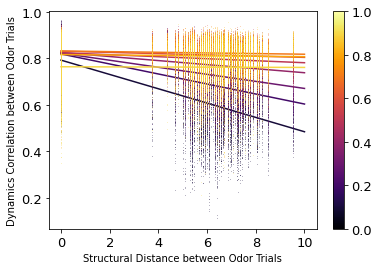

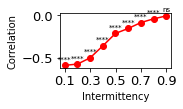

In [152]:
fig, ax = plt.subplots(figsize=(6,4))
linear = lambda x,a,b: a*x+b
correlations = []
for switch_prob in np.arange(0.1,1,0.1):
    results = pd.read_csv(f"AnalysedData/Distance_{int(switch_prob*10)}.csv")
    ax.plot(results.x2,results.y,',',alpha=0.3,color=plt.cm.inferno(switch_prob))
    popt,_ = curve_fit(linear,results.x2,results.y)
    ax.plot(np.linspace(0,10),linear(np.linspace(0,10),*popt),'-',color=plt.cm.inferno(switch_prob))
    correlations.append(pearsonr(results.x2,results.y))
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(0,1), cmap=plt.cm.inferno), ax=ax)
ax.set_xlabel("Structural Distance between Odor Trials")
ax.set_ylabel("Dynamics Correlation between Odor Trials")
fig, ax = plt.subplots(figsize=(2,1))
ax.plot(np.arange(0.1,1,0.1),np.array(correlations)[:,0],'ro-')
for i in range(9):
    plt.text(np.arange(0.1,1,0.1)[i],np.array(correlations)[:,0][i]+0.05,np.vectorize(to_significance_label)(np.array(correlations)[:,1])[i],
             ha='center',fontdict={'size':7})
plt.xticks(np.arange(0.1,1.0,0.2))
plt.xlabel("Intermittency")
plt.ylabel("Correlation")
# plt.savefig(f"Figures/LNOdorDifference_effect.svg")

In [ ]:
for switch_prob in np.arange(0.1,1,0.1):
    unzip(int(switch_prob*10))
    results = []
    for time in tqdm(np.arange(0.5,13.5,0.5)):
        for i in tqdm(range(1,11)):
            for j in [13674, 59428, 72957, 84932, 85036]:
                LN_correlations,mat,module,order = get_LN_data(i,j,time=time)
                for k in range(10):
                    correlation = np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat.flatten())[0,1]
                    random_shuffles = [np.random.choice(np.arange(30),size=30,replace=False) for x in range(1000)]
                    shuffled = np.mean([np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                    results.append((time,correlation,shuffled))
    results=np.real(np.array(results))
    results = pd.DataFrame(results,columns=["Time","Original","Shuffled"])
    results.to_csv(f"AnalysedData/LNCorrelationTimeseries_0_{int(switch_prob*10)}.csv")

    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            LN_correlations,mat,module,order = get_LN_data(i,j)
            for k in range(10):
                cluster_model = KMeans(n_clusters=int(np.max(module)))
                cluster_model.fit((1-LN_correlations[k])/2)
                f_correctpairs = rand_score(cluster_model.labels_,np.int32(module-1))
                random_clustering = [np.random.choice(np.arange(4),size=30) for x in range(1000)]
                shuffled = np.mean([rand_score(cluster_model.labels_,cluster) for cluster in random_clustering])
                results.append((f_correctpairs,shuffled))
    results = np.real(np.array(results))
    results = pd.DataFrame(results,columns=["Newman","Random"])
    results.to_csv(f"AnalysedData/LNReconstructionAnalysis_0_{int(switch_prob*10)}.csv")

    results = []
    for i in tqdm(range(1,11)):
        for j in [13674, 59428, 72957, 84932, 85036]:
            spike_dist,module_dist = get_PN_data(i,j)
            for k in range(10):
                correlation = np.corrcoef(np.nan_to_num(spike_dist[k]).flatten(),module_dist.flatten())[0,1]
                random_shuffles = [np.random.choice(np.arange(9),size=9,replace=False) for x in range(1000)]
                shuffled = np.mean([np.corrcoef(np.nan_to_num(spike_dist[k]).flatten(),module_dist[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                results.append((correlation,shuffled))
    results=np.array(results)
    results = pd.DataFrame(results,columns=["Original","Shuffled"])
    results.to_csv(f"AnalysedData/PNCorrelationAnalysis_0_{int(switch_prob*10)}.csv")

    results= [[],[]]
    for i in tqdm(range(1,11)):
        summary_matrix,within,across = odor_analysis(i)
        for j in within:
            results[0].append(j)
        for j in across:
            results[1].append(j)
    N = max(len(results[0]),len(results[1]))
    temp = np.nan*np.ones((N,2))
    temp[:len(results[0]),0] = results[0]
    temp[:len(results[1]),1] = results[1]
    results=np.real(temp)
    results = pd.DataFrame(results,columns=["Within","Across"])
    results.to_csv(f"AnalysedData/OdorComparision_0_{int(switch_prob*10)}.csv")

    results= []
    for time in tqdm(np.arange(0.5,13.5,0.5)):
        for i in range(1,11):
            _,within,across = odor_analysis(i,time=time)
            for j in within:
                if not np.isnan(j):
                    results.append((time,"Within Odors",j))
            for j in across:
                if not np.isnan(j):
                    results.append((time,"Across Odors",j))
    results=np.real(np.array(results))
    results = pd.DataFrame(results,columns=["Time","LN Dynamics Correlation","Correlation"])
    results['Time'] = np.float32(results['Time'])
    results['Correlation'] = np.float32(results['Correlation'])
    results.to_csv(f"AnalysedData/OdorComparisionTimeseries_0_{int(switch_prob*10)}.csv")

    clean_data()

Extracting : 100%|███████████████████████████████████████████████████████████████████| 501/501 [05:53<00:00,  1.42it/s]


In [58]:
def get_LN_data(mat_no,odor_no,replicate=None,time=None):
    r = []
    mat = np.loadtxt(f'../modules/networks/matrix_{mat_no}.csv',delimiter=",")
    module = np.loadtxt(f'../modules/networks/matrix_{mat_no}_modules.csv')
    order = np.argsort(module)
    if replicate is None:
        for i in filter(lambda v: ".npy" in v and f"{mat_no}_{odor_no}" in v,os.listdir('Data')):
            temp = np.load(f"Data/{i}").T
            spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
            spike_times= [np.linspace(0,12.998,12999)[k>0] for k in spikes]
            if time is not None:
                spike_times = [k[k<=time] for k in spike_times]
            event = np.array([SpikeTrain(k*q.s,t_start=0.*q.s,t_stop=13*q.s) for k in spike_times],dtype=object)
            bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
            pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
            r.append(pearson_correlation[:,order][order,:])
    else:
        temp = np.load(f"Data/data_{mat_no}_{odor_no}_{replicate}.npy").T
        spikes = np.logical_and(temp[90:,1:]>=-20,temp[90:,:-1]<-20)
        spike_times= [np.linspace(0,12.998,12999)[k>0] for k in spikes]
        if time is not None:
            spike_times = [k[k<=time] for k in spike_times]
        event = np.array([SpikeTrain(k*q.s,t_stop=13*q.s) for k in spike_times],dtype=object)
        bst = eph.conversion.BinnedSpikeTrain(list(event),bin_size=50*q.ms)
        pearson_correlation = eph.spike_train_correlation.correlation_coefficient(bst)
        r.append(pearson_correlation[:,order][order,:])
    return np.nan_to_num(np.array(r)),mat[:,order][order,:],module[order],order

In [72]:
for switch_prob in np.arange(0.1,1,0.1):
    unzip(int(switch_prob*10))
    results = []
    for time in tqdm(np.arange(1.5,13.5,1)):
        for i in range(1,11):
            for j in [13674, 59428, 72957, 84932, 85036]:
                LN_correlations,mat,module,order = get_LN_data(i,j,time=time)
                for k in range(10):
                    correlation = np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat.flatten())[0,1]
                    random_shuffles = [np.random.choice(np.arange(30),size=30,replace=False) for x in range(1000)]
                    shuffled = np.mean([np.corrcoef(np.nan_to_num(LN_correlations[k]).flatten(),1-mat[:,order][order,:].flatten())[0,1] for order in random_shuffles])
                    results.append((time,correlation,shuffled))
    results=np.real(np.array(results))
    results = pd.DataFrame(results,columns=["Time","Original","Shuffled"])
    results.to_csv(f"AnalysedData/LNCorrelationTimeseries_0_{int(switch_prob*10)}.csv")
    results = []
    for time in tqdm(np.arange(1.5,13.5,1)):
        for i in tqdm(range(1,11)):
            for j in [13674, 59428, 72957, 84932, 85036]:
                LN_correlations,mat,module,order = get_LN_data(i,j,time=time)
                for k in range(10):
                    cluster_model = KMeans(n_clusters=int(np.max(module)))
                    cluster_model.fit((1-LN_correlations[k])/2)
                    f_correctpairs = rand_score(cluster_model.labels_,np.int32(module-1))
                    random_clustering = [np.random.choice(np.arange(4),size=30) for x in range(1000)]
                    shuffled = np.mean([rand_score(cluster_model.labels_,cluster) for cluster in random_clustering])
                    results.append((time,f_correctpairs,shuffled))
    results = np.real(np.array(results))
    results = pd.DataFrame(results,columns=["Time","Newman","Random"])
    results.to_csv(f"AnalysedData/LNReconstructionTimeseries_0_{int(switch_prob*10)}.csv")
    clean_data()

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:534: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  warnings.warn(
D:\Anaconda3\envs\odor-states\lib\site-packages\elephant\spike_train_correlation.py:542: RuntimeWarning: invalid value encountered in true_divide
  res /= (stdx.T * stdx)
  0%|                                                                                           | 0/12 [00:01<?, ?it/s]


ValueError: If the input is not a spiketrain(s), it must be an MxN numpy array, each cell of which represents the number of (binned) spikes that fall in an interval - not raw spike times.

<AxesSubplot:xlabel='Time', ylabel='Shuffled'>

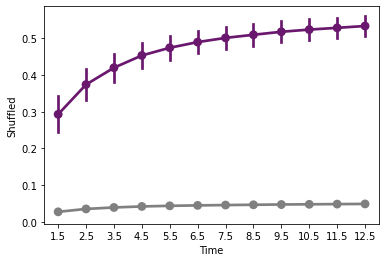

In [71]:
sns.pointplot(x="Time",y="Original",data=results,ci='sd',color=plt.cm.inferno(0.3))
sns.pointplot(x="Time",y="Shuffled",data=results,ci='sd',color='gray')

In [64]:
results

,Time,Original,Shuffled
0,1.5,0.304598,0.031489
1,1.5,0.266457,0.029789
2,1.5,0.241929,0.031665
3,1.5,0.269465,0.030477
4,1.5,0.222207,0.028992
...,...,...,...
5995,12.5,0.551140,0.044759
5996,12.5,0.595550,0.048944
5997,12.5,0.577057,0.051174
5998,12.5,0.534989,0.042653
